In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

In [2]:
#Create functions.

#Function that creates an 'observation' of the different light curve models by taking the magnitudes 
#corresponding to 24 hour cadence starting from 0.5 days.
def make_lightcurve(t, mod):
    mag = np.zeros(len(t)) 
    for ind,i in enumerate(t):
        a = np.interp(i, model[mod][:,0], model[mod][:,1])
        mag[ind] = a
    return(mag)

#Function that scales these magnitudes with distance so that they are within a range of the expected 30% error in
#the distance parameter from the GW source.
def make_scale_model(mag, rand_dist_range):
    mag_scale=[]
    for i in range(len(rand_dist_range)):
        obs = mag + 5*np.log10((rand_dist_range[i])/(dist_all_models)) #this comes from m-M = 5log(d) - 5
        mag_scale.append(obs)
    return(mag_scale)

#Function that introduces an error of ±0.25 onto the magnitudes that would come from the optical telescope.
def introduce_telescope_err(mag_scale):
    corrected_mags = []
    rand_err = np.random.uniform(-0.25, 0.25, len(mag_scale[0]))
    for mags in mag_scale:
        corrected_mags.append(mags + rand_err) #adds same 14 errors to the 14 magnitudes of all the scaled models.
    
    #Creating the cutoff magnitude for the all the models. Currently removed whilst fixing errors.
    #newarr=[]    
    #for j in range(len(corrected_mags)):
        #corrected_mags[j][corrected_mags[j] > cutoff_mag] = -1 #if the value of the magnitude in a model is greater
                                                               #than 21 (cutoff) then set that element = -1.
        #num = np.where(corrected_mags[j]==-1) #finds all elements in corrected mags where GOTO cannot observe them.
        #if len(num[0]) > 10: #GOTO has to observe at least 4 points out of 14 for the model to be observed. 
            #print('Unobservable')
    return(corrected_mags)

#Function to create a chi squared distribution.
def make_chi_squared(mag_err, mag):
    all_chi2 = []
    for mags in mag_err:
        chi2 = np.sum(np.square(mags - mag)/mag)
        all_chi2.append(chi2)
    return(all_chi2)

#Function to return a dictionary with the minimmum chi value and the model related to this minimum chi value.
#This is currently where the error is.
def return_best_model(dictionary):
    min_chi = min(dictionary.items()) #gives key and items where lowest chisquared is found.
    lowest_chi = min(min_chi[1]) #takes the lowest value in the items of the key with the lowest chi squared value.
    related_model = int(min_chi[0]) #gives the key of the lowest chisquared.
    return(min_chi, lowest_chi, related_model)

In [3]:
#Load in models.

lc = np.load('light_curves.npz')
m0 = lc['two']
m1 = lc['two_r']
m2 = lc['two_b']
m3 = lc['three']
m4 = lc['three_b']
m5 = lc['KW']
m6 = lc['BR']
m7 = lc['GW']

#Define parameters.

N = 1 #number of kn models in Universe. Currently reduced at the moment whilst fixing errors

model = [m0, m1 ,m2 ,m3 ,m4 ,m5 ,m6 ,m7] #array of all the kn models.
time = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5] #cadence of the observations in days.

dist = np.random.uniform(40,200,N) #Mpc #creates random distance between 40-200 Mpc (range we expect to detect KN).
dist_all_models = 40 #Mpc #reference distance when scaling the magnitudes.
low_dist_err = 0.7 #min distance from the 30% error range.
high_dist_err = 1.3 #max distance from the 30% error range.

cutoff_mag = 21 #GOTO will not be able to observe anything beyond this magnitude.

In [4]:
#Simulating N kilonova models in the universe.

#List of empty arrays used to append values in the loop.
array_kns = []
all_kn_distance = []
model_distance = []
min_chi2 = []
best_model = []
ind_chi2 = []
dist_ind_value = []

for j in range(N):
    
    #Create kn in universe.
    x = 5 #np.random.randint(0, 7) #chooses a random model out of the 8.
    gen_kn = make_lightcurve(time, x) #universe creates 'observation' of model with magnitudes taken at cadences.
    kn = make_scale_model(gen_kn, [dist[j]]) #places this observation model at a random distance.
    
    #Record model of kn chosen to store in dictionary later.
    array_kns.append(x)
    
    #Work out step of model over distance to give a range between min and max 30% error range.
    dist_range = np.arange(np.floor(low_dist_err*dist[j]), np.ceil(high_dist_err*dist[j]), 1)
    
    #Use functions defined and loop them over all models.
    chisquare_models = []
    for i in range(len(model)):
        magnitude = make_lightcurve(time, i) #inserting model number from 0-7 (models 1-8) and times for cadenece.
        scale = make_scale_model(magnitude, dist_range) #inserting the returned 'mag' from previous magnitude 
                                                        #function and the distance range to scale models over.
        error = introduce_telescope_err(scale) #inserting the scaled magnitudes from the scale function.
        chisquare = make_chi_squared(error, kn) #inserting the corrected magnitudes and the magnitudes from
                                                #the original kn model.
        chisquare_models.append(chisquare) #appending the chisquare values for each of the 8 models

    #Save chisquared data for each model in a dictionary.
    chi_dict = {'0':chisquare_models[0], '1':chisquare_models[1], '2':chisquare_models[2], '3':chisquare_models[3], '4':chisquare_models[4], '5':chisquare_models[5], '6':chisquare_models[6], '7':chisquare_models[7]}
    
    #Using return best model function to find the min chi and best model fit for all the models over every iteration.
    return_best_model(chi_dict)
    key_items_min_chi = return_best_model(chi_dict)[0]
    print(key_items_min_chi)
    lowest_chi = return_best_model(chi_dict)[1]
    print(lowest_chi)
    related_model = return_best_model(chi_dict)[2]
    print(related_model)
    min_chi2.append(lowest_chi)
    #print(min_chi2)
    best_model.append(related_model)
    #print(best_model)
    
    #Finding the index of the minimum chi value to find out where the distance of the model is.
    #chi_index_min = np.argmin(chisquare_models[int(related_model)])
    #ind_chi2.append(chi_index_min)
    #dist_range_index = dist_range[int(chi_index_min)]
    #dist_ind_value.append(dist_range_index)
    
    #Looping over dist_all_models N times for kn_info dict.
    #all_kn_distance.append(int(dist[j]))

('0', [14.650632866163537, 14.504754954032743, 14.36139187659175, 14.220473932429988, 14.081934132445628, 13.945708064105137, 13.811733763982598, 13.679951597985252, 13.550304148719688, 13.422736109498281, 13.297194184525013, 13.173626994837065, 13.051984989611421, 12.932220362476574, 12.81428697249673, 12.698140269521582, 12.583737223617769, 12.471036258319169, 12.359997187452816, 12.250581155314926, 12.142750579987814, 12.036469099603583, 11.931701521374055, 11.828413773219339, 11.726572857838958, 11.626146809080256, 11.527104650468663, 11.429416355773736, 11.3330528114932, 11.237985781144983, 11.144187871264727, 11.051632499012719, 10.96029386130037, 10.870146905352488, 10.781167300626352, 10.69333141201418, 10.606616274259556, 10.520999567523242, 10.436459594037364, 10.35297525579086, 10.27052603319246, 10.189091964660832, 10.108653627094125, 10.029192117174603, 9.950689033465897, 9.873126459263528, 9.79648694616113, 9.720753498297363, 9.645909557249972, 9.571938987545973, 9.498826

In [5]:
#Save KN, best fit model, min chi2 value, model distance (use indexing to find lowest) and KN distance)

kn_info = {'KN model':array_kns, 'Best fit model':best_model, 'Minimum Chi2':min_chi2}#, 'Model distance':dist_ind_value, 'KN distance':all_kn_distance}
print(kn_info)

{'KN model': [5], 'Best fit model': [0], 'Minimum Chi2': [8.254308157390927]}


In [6]:
print(chi_dict)

{'0': [14.650632866163537, 14.504754954032743, 14.36139187659175, 14.220473932429988, 14.081934132445628, 13.945708064105137, 13.811733763982598, 13.679951597985252, 13.550304148719688, 13.422736109498281, 13.297194184525013, 13.173626994837065, 13.051984989611421, 12.932220362476574, 12.81428697249673, 12.698140269521582, 12.583737223617769, 12.471036258319169, 12.359997187452816, 12.250581155314926, 12.142750579987814, 12.036469099603583, 11.931701521374055, 11.828413773219339, 11.726572857838958, 11.626146809080256, 11.527104650468663, 11.429416355773736, 11.3330528114932, 11.237985781144983, 11.144187871264727, 11.051632499012719, 10.96029386130037, 10.870146905352488, 10.781167300626352, 10.69333141201418, 10.606616274259556, 10.520999567523242, 10.436459594037364, 10.35297525579086, 10.27052603319246, 10.189091964660832, 10.108653627094125, 10.029192117174603, 9.950689033465897, 9.873126459263528, 9.79648694616113, 9.720753498297363, 9.645909557249972, 9.571938987545973, 9.498826

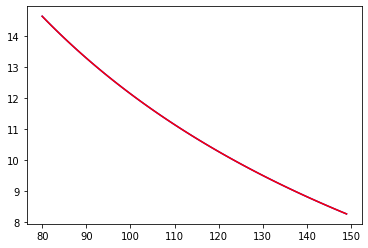

In [7]:
plt.plot(dist_range, key_items_min_chi[1], color='blue') #plotting chisquared distribution model 7 (model 0 chosen).
plt.plot(dist_range, chi_dict['0'], color='red') #plotting chisquared distribution model 0 (model 0 chosen).

In [8]:
print(min(chi_dict.items()))

('0', [14.650632866163537, 14.504754954032743, 14.36139187659175, 14.220473932429988, 14.081934132445628, 13.945708064105137, 13.811733763982598, 13.679951597985252, 13.550304148719688, 13.422736109498281, 13.297194184525013, 13.173626994837065, 13.051984989611421, 12.932220362476574, 12.81428697249673, 12.698140269521582, 12.583737223617769, 12.471036258319169, 12.359997187452816, 12.250581155314926, 12.142750579987814, 12.036469099603583, 11.931701521374055, 11.828413773219339, 11.726572857838958, 11.626146809080256, 11.527104650468663, 11.429416355773736, 11.3330528114932, 11.237985781144983, 11.144187871264727, 11.051632499012719, 10.96029386130037, 10.870146905352488, 10.781167300626352, 10.69333141201418, 10.606616274259556, 10.520999567523242, 10.436459594037364, 10.35297525579086, 10.27052603319246, 10.189091964660832, 10.108653627094125, 10.029192117174603, 9.950689033465897, 9.873126459263528, 9.79648694616113, 9.720753498297363, 9.645909557249972, 9.571938987545973, 9.498826

In [9]:
### ERROR UP TO HERE.

In [10]:
#Creating the efficiency curve.

#best_val = []
#cumulative = []
#match_dist = []
#match = 1
#non_match = 0

#array_kns = np.asarray(array_kns)
#best_model = np.asarray(best_model)

#for i in range(len(model)):
#    for j in range(len(model)):
#        kn_ind = np.where(array_kns==i)
#        best_ind = best_model[kn_ind]
#        best_val.append(best_ind)
#        if best_val[i][j] == i:
#            match_dist.append(dist_ind_value[best_val[i][0]])
#            cumulative.append(match)
#        else:
#            cumulative.append(non_match)
             
#cumsum = np.cumsum(cumulative)

#print(best_val)

#print(match_dist)

#plt.plot(cumsum)

In [11]:
#plt.figure(figsize=(9,7))
#plt.plot(dist_range, chi_dict['0'], color='black', label='Two Component Model')
#plt.plot(dist_range, chi_dict['1'], color='red', label='Red Two Component Model')
#plt.plot(dist_range, chi_dict['2'], color='blue', label='Blue Two Component Model')
#plt.plot(dist_range, chi_dict['3'], color='black', linestyle='dashed', label='Three Component Model')
#plt.plot(dist_range, chi_dict['4'], color='blue', linestyle='dashed', label='Blue Three Component Model')
#plt.plot(dist_range, chi_dict['5'], color='green', label='Kawaguchi et al.')
#plt.plot(dist_range, chi_dict['6'], color='orange', label='Barbieri et al.')
#plt.plot(dist_range, chi_dict['7'], color='fuchsia', label='GW170817')
#plt.xlabel('Distance (Mpc)')
#plt.ylabel('$\chi^{2}$')
#plt.ylim(0,1)
#plt.xlim(28,51)
#plt.grid()
#plt.legend()
#plt.savefig('chi_ehanced.png')

In [12]:
#Simulating where GOTO is in the world

#ra = np.random.normal(np.pi, np.pi/4, 1000000)
#dec = np.random.normal(0, np.pi/8, 1000000)

#goto_loc = 